<H1> Filtering the effect of general topological signal by scPrisma</h1>

In this tutorial, we will demonstrate how to filter out the variance which is explained by a covarainace matrix which is provided by the user (in contrast to the examples in scPrisma manuscript, which were focused on cyclic topology).

Few design principles for designing theoretical covaraince matrix:
1. scPrisma was designed for continoius topologies, and especially circular topology (were we have closed formula for the spectrum). The ideal design way is to create similiar "toy model" (has been done for the circular topology in the "Methods" section), find its appropriate covariance matrix and perform numerical eigen decomposition. Note: as been writen in the discussion, for complex topologies (other than cyclic) the reconstruction task would be very challenging.
2. The covariance matrix should to be symmetric PSD matrix (for enable numerical eigendecomposition) with ones over the diagonal of the matrix.
3. In some scenarios, it is recommended to eliminate the dominant eigenvector, particularly when it is an 'offset' eigenvector, as in the case of a cyclic covariance matrix, where the lead eigenvector is a constant eigenvector.

As a practical example, we will apply batch correction to four datasets of pancreatic cells (obtained from the <a href="https://academic.oup.com/bioinformatics/article/36/3/964/5545955">BBKNN</a> paper).
It is recommended to follow the pre-processing and parameter selection procedures outlined in the scPrisma manuscript in order to optimize the results of the analysis.



In [1]:

import scPrisma
import scanpy as sc
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import normalize
import torch
from sklearn.preprocessing import MultiLabelBinarizer



In [2]:
if torch.cuda.is_available(): 
 device = "cuda:0" 
else: 
 device = "cpu" 

In [3]:
device

'cuda:0'

In [4]:
adata_all = sc.read('pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')
adata_all

/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 14693 × 2448
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Designing covariance matrix 

In [5]:
cov = np.zeros((adata_all.shape[0],adata_all.shape[0]))
for i , j in enumerate(adata_all.obs["batch"]):
        cov[i,:]+=np.array(adata_all.obs["batch"]==j,dtype=int)


In [6]:
adata_corrrected = adata_all.copy()

Iteration number: 1
torch.cuda.memory_allocated: 2.816086GB


/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


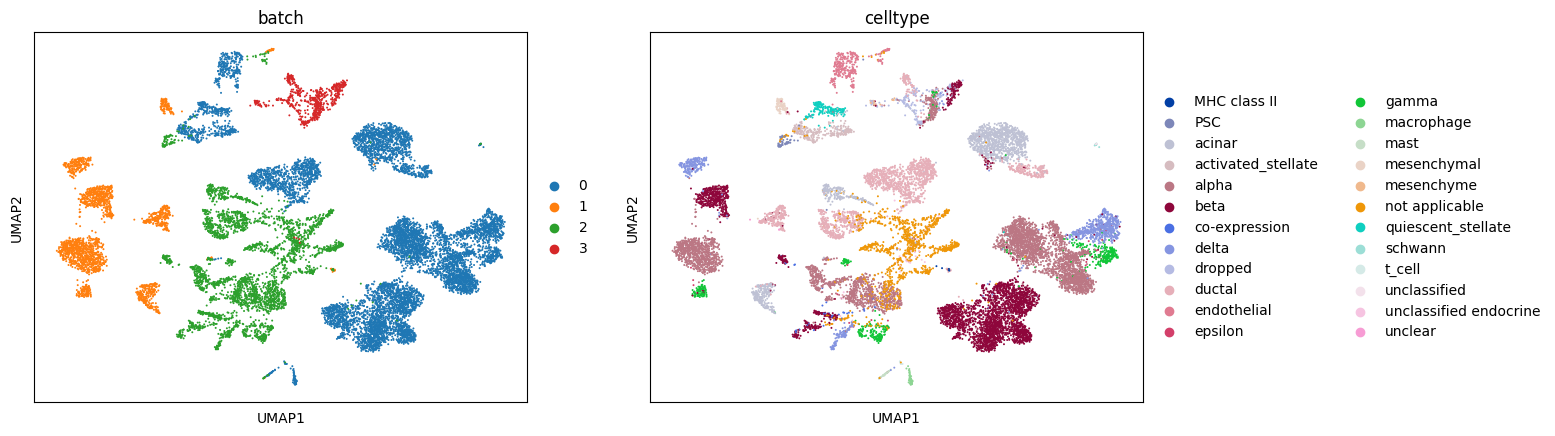

/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


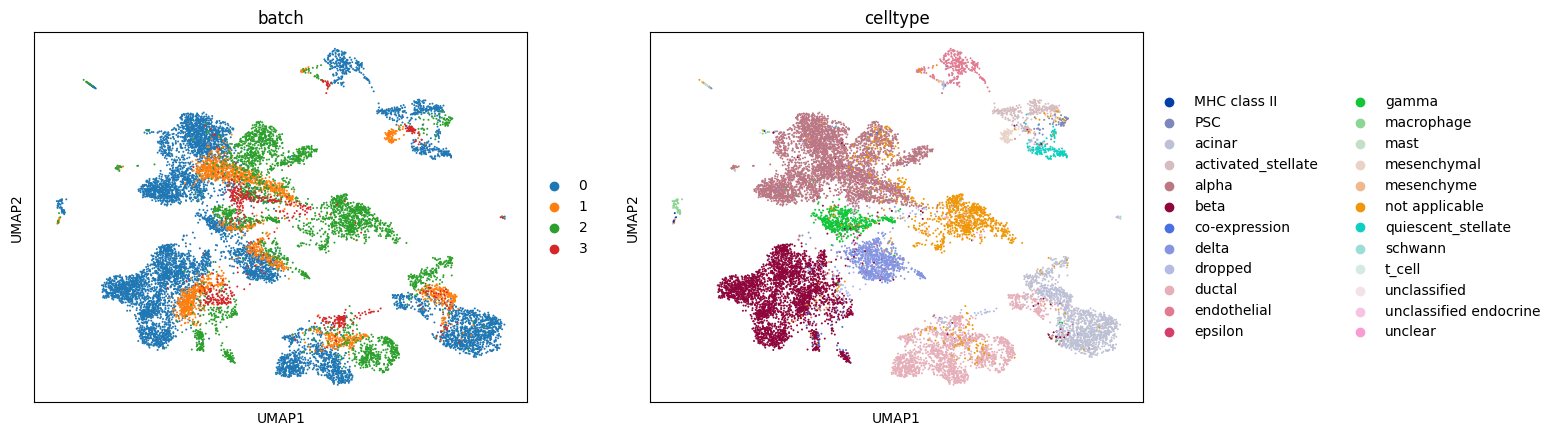

In [7]:
F = scPrisma.algorithms_torch.filter_general_covariance_torch(adata_corrrected.X,cov, regu=0, device=device)
adata_corrrected.X = adata_corrrected.X *F
sc.pp.pca(adata_all)
sc.pp.pca(adata_corrrected)
sc.pp.neighbors(adata_all)
sc.pp.neighbors(adata_corrrected)
sc.tl.umap(adata_all)
sc.tl.umap(adata_corrrected)
sc.pl.umap(adata_all, color=['batch','celltype'])
sc.pl.umap(adata_corrrected, color=['batch','celltype'])


In [8]:
from sklearn import metrics

In [9]:
print("silhouette_score between different batches:")
print("Raw data:")
print(metrics.silhouette_score(adata_all.obsm['X_pca'],adata_all.obs['batch']))
print("Corrected data:")
print(metrics.silhouette_score(adata_corrrected.obsm['X_pca'],adata_corrrected.obs['batch']))
print("silhouette_score between different celltypes:")
print("Raw data:")
print(metrics.silhouette_score(adata_all.obsm['X_pca'],adata_all.obs['celltype']))
print("Corrected data:")
print(metrics.silhouette_score(adata_corrrected.obsm['X_pca'],adata_corrrected.obs['celltype']))


silhouette_score between different batches:
Raw data:
0.21305908
Corrected data:
-0.10195794
silhouette_score between different celltypes:
Raw data:
0.047459804
Corrected data:
0.091102235
